
# Melanoma detector

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
import torch.nn.functional as F

import numpy as np


### Define variables

In [47]:
device ='cpu'
if torch.cuda.is_available:
    device = 'cuda'
    
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

learning_rate = 0.001

### Load the data

In [48]:
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {'training' : transforms.Compose([transforms.Resize(224),
                                                    transforms.CenterCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.RandomRotation(90),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(means, std)]),
                   
                   'validation' : transforms.Compose([transforms.Resize(225),
                                                      transforms.CenterCrop(224),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(means, std)]),
                   
                   'testing' : transforms.Compose([transforms.Resize(225),
                                                   transforms.CenterCrop(224),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(means, std)])                                     
                }


# DONE: Load the datasets with ImageFolder
image_datasets = {'training' : datasets.ImageFolder(train_dir,transform=data_transforms['training'],),
                  'validation' : datasets.ImageFolder(valid_dir,transform=data_transforms['validation']),
                  'testing' : datasets.ImageFolder(test_dir,transform=data_transforms['testing'])
                 }

# DONE: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'training' : torch.utils.data.DataLoader(image_datasets['training'],batch_size= 128, shuffle= True),
               'validation' : torch.utils.data.DataLoader(image_datasets['validation'],batch_size= 32, shuffle= True),
               'testing' : torch.utils.data.DataLoader(image_datasets['testing'],batch_size= 32, shuffle= False)
              }

In [49]:
training_images, training_labels = next(iter(dataloaders['training']))
validation_images, validation_labels = next(iter(dataloaders['validation']))


### Get the index of each class

In [50]:
class_to_idx = image_datasets['training'].class_to_idx

idx_to_class = dict([val,key] for key,val in class_to_idx.items())

In [51]:
print(class_to_idx)

{'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2}


### Lets have a look at the training transformed imaged

In [52]:
def show_img(imgs,label):
    fig, ax = plt.subplots(figsize=(15, 8))
        
    columns = 4
    rows = 2
    
    for i in range(1, (columns*rows) + 1):        
        img = imgs[i-1].transpose(0,2)
        img = np.array(img) 
        img = std * img + means
        img = np.clip(img, 0, 1)            
        
        ax1 = fig.add_subplot(rows, columns, i)
        ax.axis('off')
        ax1.set_title(label[i-1])
        plt.axis('off')        
        plt.imshow(img)
        
    plt.show()

In [53]:
training_images_sampler, training_labels_sampler  = training_images[0:9], training_labels[0:9]
training_classes_sampler = [idx_to_class[x] for x in training_labels_sampler.numpy()]

validation_images_sampler, validation_labels_sampler  = validation_images[0:9], validation_labels[0:9]
validation_classes_sampler = [idx_to_class[x] for x in validation_labels_sampler.numpy()]


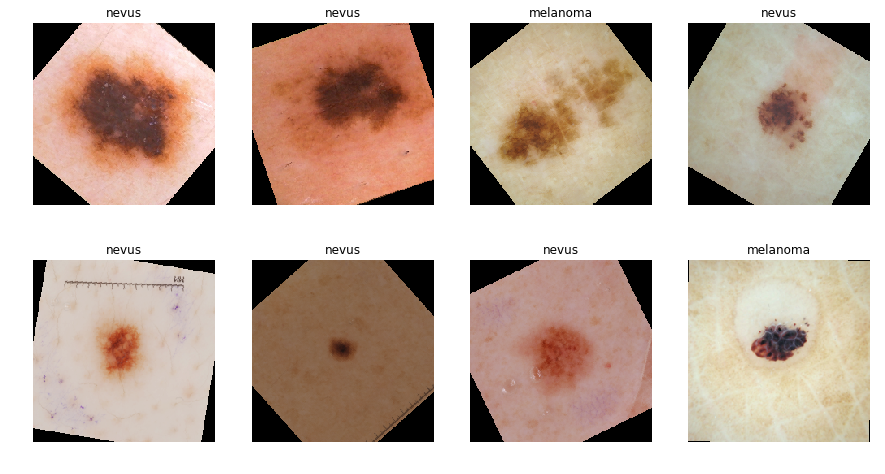

In [54]:
show_img(training_images_sampler, training_classes_sampler)

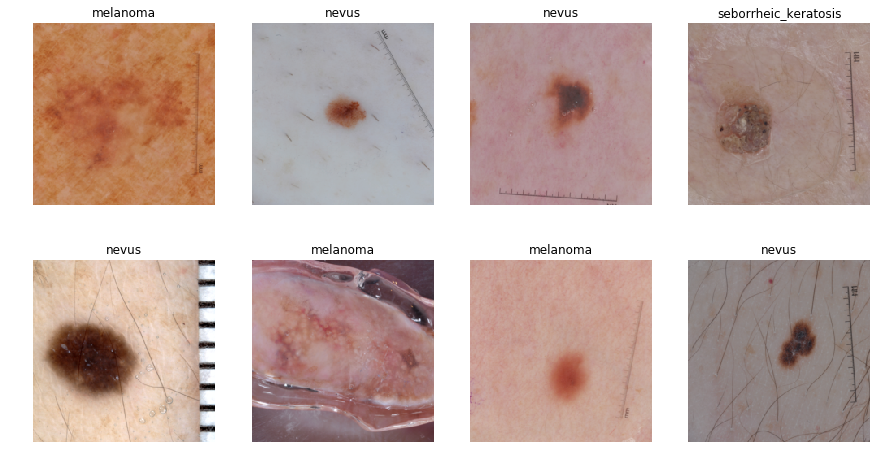

In [55]:
show_img(validation_images_sampler, validation_classes_sampler)

In [56]:
model = models.densenet161(pretrained=True)
classifier_input_size = model.classifier.in_features

/home/george/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [57]:
# Freeze layers
for param in model.parameters():
    param.requires_grad = False

In [58]:
def create_classifier(output_classes):
    classifier = nn.Sequential(
        nn.Linear(classifier_input_size,512),
        nn.Dropout(),    
        nn.ReLU(),        
        nn.Linear(512,256),
        nn.ReLU(), 
        #nn.Dropout(),
        nn.Linear(256,128),
        nn.ReLU(),
        #nn.Dropout(),
        nn.Linear(128,output_classes),
        nn.LogSoftmax(dim = 1))
    return classifier

In [59]:
classifier = create_classifier(3)

In [60]:
model.classifier = classifier
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [67]:
def test_accuracy(model,dataloader,criterion):
    loss = 0
    accuracy = 0
    model.eval()
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)       
        
        output = model.forward(images)
        loss += criterion(output,labels).item()
        
        ps = torch.exp(output)
                   
        # Each probability consist in an array of probabilities, the predicted class is the
        # highest probability of each one, so we need to get the max of the probabilitie for each 
        # prediction in order to find the predicted_class         
        
        predicted_classes = ps.max(dim=1)[1]
        
        # To find the correct classified items we compare labels with the predicted_classes
        # and we will get back an array of booleans with 1 if the prediction was correct or
        # 0 otherwise
                
        correct_predictions = (labels.data == predicted_classes)

        accuracy += correct_predictions.type(torch.FloatTensor).mean()
        
    return loss, accuracy

In [68]:
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)

In [69]:
def train_network(model, epochs):
# Train Network
    print('Training started on {} ...'.format(device))
    print_every = 5
    step = 0
    running_loss = 0
    validation_data = dataloaders['validation']
    len_val = len(validation_data)

    model = model.to(device)    

    for epoch in range(epochs):
        running_loss = 0    
        model.train()

        for inputs, y in dataloaders['training']:
            step += 1
            adam_optimizer.zero_grad()
            inputs, y = inputs.to(device), y.to(device)

            y_hat = model.forward(inputs)

            loss = criterion(y_hat,y)
            loss.backward()

            adam_optimizer.step()

            running_loss += loss.item()

            if step %  print_every == 0:
                model.eval()

                with torch.no_grad():
                    test_loss, accuracy = test_accuracy(model,validation_data,criterion)

                print("Epoch: {}/{}... ".format(epoch+1, epochs),
                      "Loss: {:.3f}".format(running_loss/print_every),
                      "Test Loss: {:.3f}".format(test_loss/len_val),
                      "Test Accuracy: {:.3f}".format(accuracy/len_val))

                running_loss = 0
                model.train()
    print('Training finished...')
    train_executed = True

In [71]:
train_network(model,3)

Training started on cuda ...
Epoch: 1/3...  Loss: 0.642 Test Loss: 0.755 Test Accuracy: 0.677
Epoch: 1/3...  Loss: 0.641 Test Loss: 0.731 Test Accuracy: 0.689
Epoch: 1/3...  Loss: 0.691 Test Loss: 0.742 Test Accuracy: 0.663
Epoch: 2/3...  Loss: 0.549 Test Loss: 0.753 Test Accuracy: 0.656
Epoch: 2/3...  Loss: 0.613 Test Loss: 0.761 Test Accuracy: 0.681
Epoch: 2/3...  Loss: 0.607 Test Loss: 0.727 Test Accuracy: 0.692
Epoch: 3/3...  Loss: 0.354 Test Loss: 0.696 Test Accuracy: 0.692
Epoch: 3/3...  Loss: 0.573 Test Loss: 0.725 Test Accuracy: 0.677
Epoch: 3/3...  Loss: 0.641 Test Loss: 0.704 Test Accuracy: 0.714
Training finished...


We achieved a max of **71.4% accuracy** on the validation set, now lets see how well it performs in the testing set!

In [ ]:
_, accuracy = test_accuracy(model,dataloaders['testing'],criterion)

In [88]:
def format_accuracy(accuracy, dataloader_name):
    length_testing_data = len(dataloaders[dataloader_name])
    rounded_accuracy = round(((accuracy.item()/length_testing_data) * 100),2)
    print('Accuracy on the {} set is: {}%'.format(dataloader_name,rounded_accuracy))

In [90]:
format_accuracy(accuracy,'testing')

Accuracy on the testing set is: 67.49%


## Densenet conclusions
For my initial experiment I decided to use densenet as my pre-trained network, and overall is working pretty well.

I decided to stop training it after 6 epochs as I couldn't get it to learn much more from epoch 3, so in order to avoid over fitting better stop early.

On the **validation** set we got **74.4%** accuracy   
On the **testing** set we got **67.49%** accuracy

Although it is a good starting point, it is not good enough to be used in the real world, I will try to improve its accuracy.